In [46]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import glob, json
from scipy import stats
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, localRFM, localSkip, deepSkip, deepRFM, localDeepRFM, localDeepSkip
# import parallel_euler as arch1
import torch, time
from torch import nn
import config
# warnings.filterwarnings('ignore'

dynamical_system = 'L96'
L = 200
Uo = torch.tensor(np.load(f'../data/{dynamical_system}/train.npy'))[:,:100000]
Vo = torch.tensor(np.load(f'../data/{dynamical_system}/test.npy'))
# Uo = torch.tensor(np.load(f'../data/{dynamical_system}-{L}/train.npy'))[:,:100000]
# Vo = torch.tensor(np.load(f'../data/{dynamical_system}-{L}/test.npy'))
# Uo = torch.tensor(ks0.ks32(dt=0.01, tmax=300)[:, 4000:-1000])
noise =  0.001*torch.randn(size=Uo.shape)
Uon = Uo + noise

L0, L1 = 0.4, 3.5
D, D_r, B = 3, 2048, 1
beta = 1e-5
data_folder = '../data'
G, I = 2,2                                                                                         

drf_args = [D_r, 1, L0, L1, Uo, beta, 'LocalSkip', f'{data_folder}/temp/localSkipKS/depth-{B}', False, G, I]
b = localSkip.BatchDeepRF(Uo, Vo, *drf_args)
start = time.time()
b.drf.learn(Uo, 42)

bn = localSkip.BatchDeepRF(Uo, Vo, *drf_args)
bn.drf.learn(Uon, 42)
end = time.time()

print(f"Time taken = {end-start}s")
# kwargs = {200:{'error_threshold': 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.094},\
#           22:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.043},\
#           12:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.003},\
#          '13_5':{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.059},\
#          '200-001':{'error_threshold': 0.25, 'dt': 0.001, 'Lyapunov_time': 1/0.094},}
kwargs = {200:{'error_threshold': 0.25, 'dt': 0.01, 'Lyapunov_time': 1/2.27}}
print(b.drf.compute_tau_f(Vo[:10], **kwargs[L])[0].mean())
print(bn.drf.compute_tau_f(Vo[:10], **kwargs[L])[0].mean())

@ut.timer
def get_eval(batch):
    eval = torch.zeros_like(Uo.T)
    j = 0
    for i in range(10):
        eval[j:j+10000] = batch.drf.forecast(Uo.T[j:j+10000])
        j += 10000
    return eval

Time taken = 4.9938130378723145s
Time taken by compute_tau_f is 1.4684 seconds
tensor(4.9736)
Time taken by compute_tau_f is 1.4537 seconds
tensor(4.9963)


**Look at loss**

In [51]:
X = Uo.T[:-1][..., b.drf.net.idx][:, b.drf.net.Ng//2, :]
Y = (Uo.T[1:] - Uo.T[:-1])[..., b.drf.net.idy][:, b.drf.net.Ng//2, :]

Xn = Uon.T[:-1][..., bn.drf.net.idx][:, bn.drf.net.Ng//2, :]
Yn = (Uon.T[1:] - Uon.T[:-1])[..., bn.drf.net.idy][:, bn.drf.net.Ng//2, :]

phi = torch.tanh(b.drf.net.inner[0](X)).detach()
phin = torch.tanh(bn.drf.net.inner[0](Xn)).detach()
phin_ = torch.tanh(bn.drf.net.inner[0](X)).detach()

Yphi = Y.T@phi
Yphin = Yn.T@phin

# eval = torch.tensor(np.load('../data/temp/eval.npy'))
# evaln = torch.tensor(np.load('../data/temp/evaln.npy'))

w = torch.sqrt((b.drf.net.outer[0].weight.detach()**2).sum())
wn = torch.sqrt((bn.drf.net.outer[0].weight.detach()**2).sum())
print(w, wn)

loss = ((b.drf.net.outer[0](phi) - Y)**2).sum() #+ beta*w**2
lossn = ((bn.drf.net.outer[0](phin) - Yn)**2).sum() #+ beta*wn**2
lossn_ = ((bn.drf.net.outer[0](phin_) - Y)**2).sum()
print(loss, lossn, lossn_)

tensor(178.0290) tensor(178.0346)
tensor(0.1759, grad_fn=<SumBackward0>) tensor(0.5717, grad_fn=<SumBackward0>) tensor(0.1759, grad_fn=<SumBackward0>)


**Condition number of the invertible matrix**

In [52]:
a0 = phi.T@phi
a = a0 + beta*torch.eye(D_r)

a0n = phin.T@phin 
an = a0n + beta*torch.eye(D_r)

print(np.linalg.det(a0n), torch.linalg.det(an))


con = torch.linalg.cond(a)
conn = torch.linalg.cond(an)

print(con, conn)

0.0 tensor(0.)
tensor(1.6485e+13) tensor(1.6487e+13)


In [53]:
torch.linalg.cond(a0), torch.linalg.cond(a0n)

(tensor(3.3752e+19), tensor(7.6157e+18))

**Distribution of entries of W**

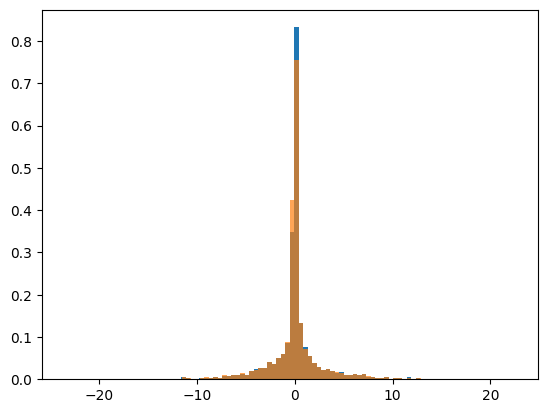

In [54]:
W = b.drf.net.outer[0].weight.detach().numpy()
Wn = bn.drf.net.outer[0].weight.detach().numpy()
plt.hist(W.flatten(), bins=100, density=True)
plt.hist(Wn.flatten(), bins=100, alpha=0.7, density=True)
plt.savefig('../data/plots/W-dist.png')

**Look at predicted trajectories**

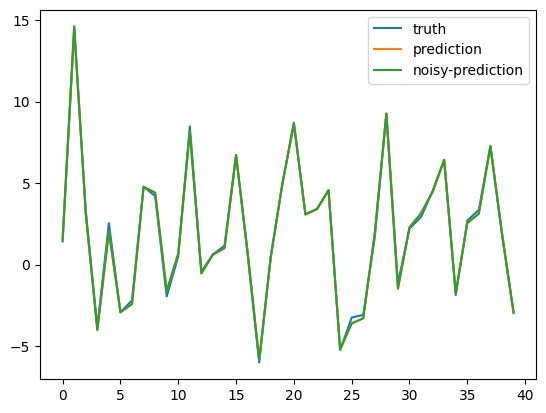

In [4]:
n = 100
v = Vo[0][:, :n]
vh = b.drf.multistep_forecast(v[:, 0], n)
vhn = bn.drf.multistep_forecast(v[:, 0], n)
plt.plot(v[:, 20], label='truth')
plt.plot(vh[:, 20], label='prediction')
plt.plot(vhn[:, 20], label='noisy-prediction')
plt.legend()

In [8]:
np.linalg.cond(W), np.linalg.cond(Wn), np.linalg.cond(a0), np.linalg.cond(a0n), np.linalg.cond(Yphi), np.linalg.cond(Yphin)

(1329.0411806335621,
 11.913957374151915,
 2.5691229591189725e+19,
 1.3683178003578534e+20,
 226964.51394674115,
 16459.364687376154)

In [55]:
np.linalg.cond(Y[:10000]), np.linalg.cond(Yn[:10000])

(1.0527783905453625, 1.0527701360085782)

In [56]:
np.linalg.cond(phi[:100]), np.linalg.cond(phin[:100])

(1.441684720971488e+17, 15126467278.249718)

In [57]:
r = np.random.permutation(len(Y))[:10000]
_, sY, _ = np.linalg.svd(Y[r], full_matrices=True)
_, sYn, _ = np.linalg.svd(Yn[r], full_matrices=True)

In [58]:
sY

array([26.86208274, 25.82590306])

In [59]:
sYn

array([26.86134681, 25.82531657])

In [22]:
5136281629698/1e12

5.136281629698

Text(0, 0.5, 'Y[0]')

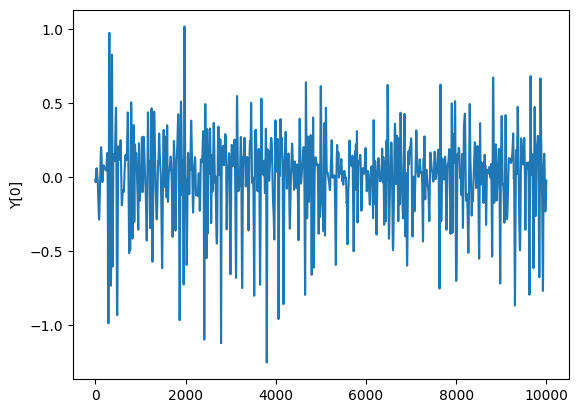

In [67]:
plt.plot(Y[:10000, 0])
plt.ylabel('Y[0]')
# plt.savefig(f'../data/plots/{dynamical_system}_Y.png')

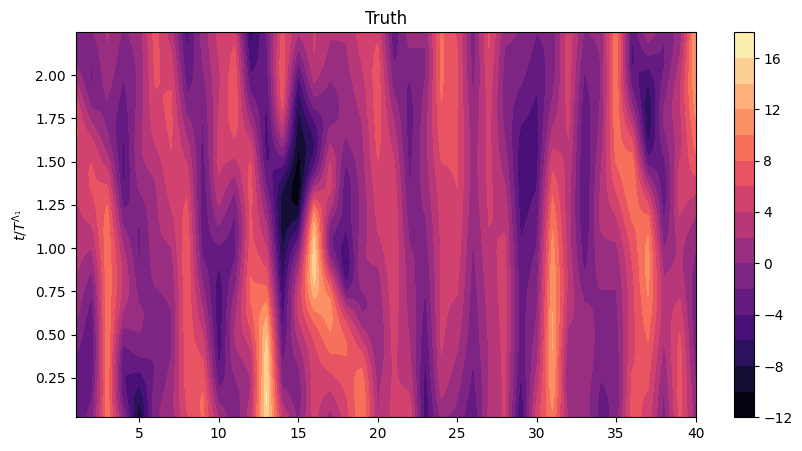

In [70]:
i = 500
ut.waterfall(Uo[:, :99], **kwargs[L])
# ut.waterfall(Y.T[:, :99], **kwargs[L])

In [73]:
Y.mean(axis=0)

tensor([8.7119e-06, 4.5737e-06, 2.6611e-06, 3.1211e-06, 5.5363e-06, 9.1139e-06,
        1.2799e-05, 1.5384e-05])

In [7]:
np.abs(Y).min()

tensor(8.0818e-08)

In [68]:
np.abs(Y[0]).min()

tensor(0.0202)

In [21]:
x0 = 10**(-0.8) * np.random.normal(size=10)
x1 = 10**(-0.8) * np.random.normal(size=10)
x2 = 10**(-0.8) * np.random.normal(size=10)
x3 = 10**(-0.8) * np.random.normal(size=10)
x4 = 10**(-0.5) * np.random.normal(size=10)
x5 = np.random.normal(size=10)

w = np.vstack((x0, x1, x2)) 
np.linalg.svd(w, full_matrices=True)[1]

array([0.83753713, 0.53863233, 0.36838651])

(array([   6.,    5.,   11.,    6.,    4.,    9.,   13.,   19.,   13.,
          42.,   41.,   41.,   44.,   70.,   54.,   55.,   74.,   82.,
         104.,  123.,  161.,  176.,  190.,  232.,  283.,  335.,  351.,
         401.,  453.,  502.,  632.,  634.,  790.,  771.,  845.,  942.,
        1021., 1028., 1115., 1348., 1384., 1551., 1593., 1849., 1940.,
        2137., 2248., 2355., 2512., 2639., 2758., 2927., 2934., 3015.,
        3179., 3024., 2999., 3115., 3025., 2931., 2782., 2523., 2538.,
        2426., 2319., 2260., 2254., 2127., 2075., 1920., 1645., 1649.,
        1466., 1310., 1268., 1131.,  906.,  838.,  646.,  511.,  425.,
         368.,  333.,  276.,  224.,  155.,   89.,   92.,   69.,   78.,
          52.,   32.,   29.,   12.,    5.,    8.,    4.,    4.,    4.,
           5.]),
 array([-0.86057983, -0.84830258, -0.83602533, -0.82374809, -0.81147084,
        -0.7991936 , -0.78691635, -0.7746391 , -0.76236186, -0.75008461,
        -0.73780736, -0.72553012, -0.71325287, -0.700975

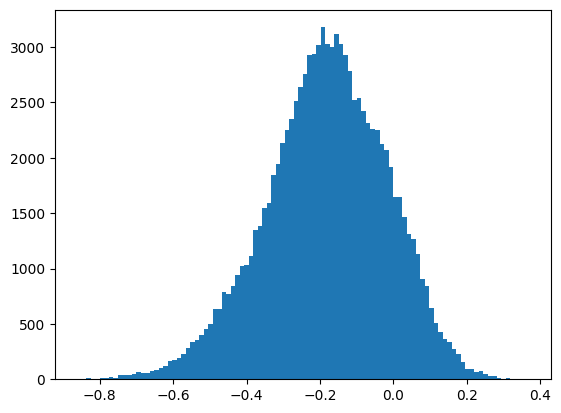

In [12]:
plt.hist(np.log10(n), bins=100)

In [63]:
x, y = Y[np.argmax(n)], Y[np.argmin(n)]

xy = np.dot(x, y)
xm = n[np.argmax(n)]
ym = n[np.argmin(n)]
sin = np.sqrt(1 - (xy / xm*ym)**2) 

est = 1/((ym/xm) * sin)

In [64]:
est

16.893850905392917

In [34]:
y/

8.951973255533157e-06

(array([1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 7.000e+00, 7.000e+00, 3.000e+00, 6.000e+00, 1.000e+01,
        1.700e+01, 1.600e+01, 2.100e+01, 1.500e+01, 2.400e+01, 1.900e+01,
        1.600e+01, 4.600e+01, 4.800e+01, 6.000e+01, 6.900e+01, 7.600e+01,
        9.000e+01, 1.160e+02, 1.400e+02, 1.690e+02, 1.960e+02, 2.370e+02,
        2.750e+02, 2.720e+02, 3.060e+02, 3.740e+02, 4.420e+02, 5.860e+02,
        6.670e+02, 7.310e+02, 8.530e+02, 9.870e+02, 1.185e+03, 1.430e+03,
        1.529e+03, 1.808e+03, 2.001e+03, 2.451e+03, 2.709e+03, 3.163e+03,
        3.549e+03, 4.173e+03, 4.977e+03, 5.953e+03, 7.382e+03, 8.254e+03,
        9.072e+03, 7.730e+03, 5.547e+03, 4.328e+03, 3.363e+03, 2.801e+03,
        2.213e+03, 1.603e+03, 1.344e+03, 1.084e+03, 7.950e+02, 6.080e+02,
        4.500e+02, 3.440e+02, 2.990e+0

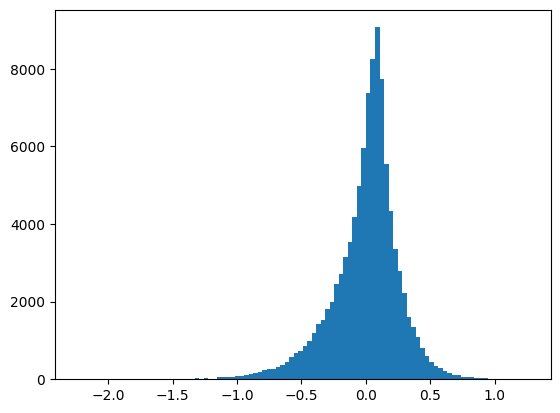

In [66]:
plt.hist(Y[:, 1], bins=100)

In [39]:
np.linalg.norm(np.random.normal(size=(8, 10000)), axis=0).mean()

2.7397976458486464

In [44]:
Uo.shape

torch.Size([40, 100000])

In [71]:
torch.linalg.cond(Uon.T[:10000])

tensor(7.1540)